In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import sys

In [2]:
def find_nearest_index(array, value):
    array = np.asarray(array)
    result = (np.abs(array - value)).argmin()
    return result

def cul_interval(value, confi):
    # 计算标称置信度
    std_confi = 100 - confi
    # 读取源数据，计算标准间隔
    data_path = "datasets_raw_processed.csv"
    train_data = pd.read_csv(filepath_or_buffer=data_path).iloc[:,1]
    train_data = np.array(train_data).astype('float')
    x = np.linspace(start=train_data.min()-1, stop=train_data.max()+1, num=len(train_data)*5)
    # print(len(x))
    spli = (train_data.max() - train_data.min())/(len(train_data)*5) # 这里的10与核密度估计部分参数需要保持一致
    # print(spli)

    # 读取面积数据
    x_prob_area_df = pd.read_csv("raw_KDE_prob_area.csv")["prob_area"]
    x_prob_area = np.asarray(x_prob_area_df).astype('float')
    # print(x_prob_area.shape)

    # 计算在数组x中与value最相近的数值下标
    index = find_nearest_index(array=x, value=value)
    area = x_prob_area[index]
    area_a = x_prob_area[index] - (std_confi/2) # 计算下界值
    area_b = x_prob_area[index] + (std_confi/2) # 计算上界值
    # 计算在数组x_prob_area中与area_a和area_b最相近的数值下标
    index_a = find_nearest_index(array=x_prob_area, value=area_a)
    index_b = find_nearest_index(array=x_prob_area, value=area_b)
    # 计算下界值
    a = value - (index - index_a)*spli
    # 计算上界值
    b = value + (index_b - index)*spli
    return a,b

In [3]:
class LstmModel(nn.Module):
    def __init__(self, inputSize=5, hiddenSize=6):
        super().__init__() 
        self.lstm = nn.LSTM(input_size=inputSize, hidden_size=hiddenSize, num_layers=2) 
        self.output = nn.Linear(6,1)  # 线性输出
    
    def forward(self,x):
        x1, _ = self.lstm(x)  
        a, b, c = x1.shape 
        out = self.output(x1.view(-1,c))  # 只有三维数据转化为二维才能作为输入 
        # 重新将结果转化为三维 
        out = out.view(a,b,-1) 
        return out

In [4]:
def createDataset(dataset, look_back):
    dataX = [] 
    dataY = [] 
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:i+look_back]) 
        dataY.append(dataset[i+look_back]) 
    dataX = torch.tensor(dataX) 
    dataX = dataX.reshape(-1, 1, look_back) 
    dataY = torch.tensor(dataY) 
    dataY = dataY.reshape(-1, 1, 1) 
    return dataX, dataY

In [5]:
def splitData(data, rate):
    dataX, dataY = data  
    nSample = dataX.shape[0] 
    nTrain = int(nSample*rate) 
    # shuffledIndices = torch.randperm(nSample) 
    trainData = (dataX[:nTrain], dataY[:nTrain])
    testData = (dataX[nTrain:], dataY[nTrain:])
    return trainData, testData

In [6]:
# 模型训练
def training_loop(Epochs, model, optimizer, lossFn, trainData, testData=None): 
    trainX, trainY = trainData
    trainX = trainX.float()
    trainY = trainY.float() 
    if testData is not None:
        testX, testY = testData     
    for epoch in range(1, Epochs+1): 
        optimizer.zero_grad()  # 梯度清0  
        trainP = model(trainX) 
        loss = lossFn(trainP, trainY) 
        loss.backward()  # 反向传播 
        optimizer.step() 
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")
    print("模型训练完成！")
    return model 

In [7]:
# 加载发电数据
power_data = pd.read_csv('datasets_raw_processed.csv')
raw_data = power_data.iloc[:,1].to_numpy()

In [8]:
# 数据归一化
max_power = power_data['power'].max()
min_power = power_data['power'].min()
norm_data = []
for i in range(0,len(power_data)):
    result = (power_data.iloc[i,1] - min_power)/(max_power - min_power)
    norm_data.append(result)
data = createDataset(dataset=norm_data, look_back=36) # 以24个数据（一天）作为一次输入

# 划分数据集为训练集和测试集
rate = 0.9
epoch = 2000
train_data, test_data = splitData(data=data, rate=rate)

In [9]:
# 定义模型
lr = 0.001
LSTM = LstmModel(inputSize=36) # inputsize与look_back保持一致
optimizer = optim.Adam(LSTM.parameters(), lr=lr)
loss = nn.MSELoss()
LSTM.train()
# 训练模型
lstm = training_loop(Epochs=epoch, model=LSTM, optimizer=optimizer, lossFn=loss, trainData=train_data)

Epoch: 100, Loss: 0.046462371945381165
Epoch: 200, Loss: 0.02903929352760315
Epoch: 300, Loss: 0.020536599680781364
Epoch: 400, Loss: 0.016483616083860397
Epoch: 500, Loss: 0.0144164664670825
Epoch: 600, Loss: 0.013027547858655453
Epoch: 700, Loss: 0.012198073789477348
Epoch: 800, Loss: 0.011686663143336773
Epoch: 900, Loss: 0.011308116838335991
Epoch: 1000, Loss: 0.011002685874700546
Epoch: 1100, Loss: 0.010762663558125496
Epoch: 1200, Loss: 0.010583626106381416
Epoch: 1300, Loss: 0.01045667752623558
Epoch: 1400, Loss: 0.01036943681538105
Epoch: 1500, Loss: 0.010307377204298973
Epoch: 1600, Loss: 0.010261595249176025
Epoch: 1700, Loss: 0.010226363316178322
Epoch: 1800, Loss: 0.0101972296833992
Epoch: 1900, Loss: 0.010172187350690365
Epoch: 2000, Loss: 0.01014952827244997
模型训练完成！


In [10]:
# 预测
LSTM.eval()
start = 4626
end = start+37
dataX, dataY = data
dataX = dataX.float()
dataY = dataY.float()
dataY = dataY.view(-1).data.numpy() # 展开为1维
dataY = dataY * (max_power - min_power) + min_power # 反归一化
# measures = dataY[start-37:end-37]
measures = dataY[-108:]
print(measures.tolist())

predict_data = lstm(dataX)
predict_data = predict_data.view(-1).data.numpy() # 展开为1维
predict_data = predict_data * (max_power - min_power) + min_power # 反归一化
# predict = predict_data[start-37:end-37]
predict = predict_data[-108:]
print(predict.tolist())

[12.792999267578125, 18.232500076293945, 22.01099967956543, 24.02400016784668, 26.22949981689453, 29.62299919128418, 39.0994987487793, 54.63149642944336, 65.27400207519531, 73.80449676513672, 81.22949981689453, 85.3324966430664, 88.89100646972656, 91.03050231933594, 90.30449676513672, 88.60499572753906, 84.8429946899414, 76.94499969482422, 70.28450012207031, 58.35499954223633, 47.45949935913086, 40.48550033569336, 37.845497131347656, 33.82500076293945, 29.875999450683594, 30.29949951171875, 27.989500045776367, 20.82849884033203, 15.25149917602539, 11.220000267028809, 7.8429999351501465, 4.977499961853027, 0.9404999613761902, 0.3960000276565552, 0.9460000395774841, 4.542999744415283, 6.753999710083008, 10.482999801635742, 15.982999801635742, 19.695499420166016, 21.493999481201172, 23.875499725341797, 28.456998825073242, 39.36900329589844, 51.65049743652344, 63.5525016784668, 71.29650115966797, 79.0679931640625, 82.83549499511719, 86.69650268554688, 88.39599609375, 88.75900268554688, 88.

C:\Resources\Programming\anaconda3-2023.9\envs\GP_torch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26228 (\N{CJK UNIFIED IDEOGRAPH-6674}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Resources\Programming\anaconda3-2023.9\envs\GP_torch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Resources\Programming\anaconda3-2023.9\envs\GP_torch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Resources\Programming\anaconda3-2023.9\envs\GP_torch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Resources\Programming\anaconda3-2023.9\envs\GP_torch\lib\site-pac

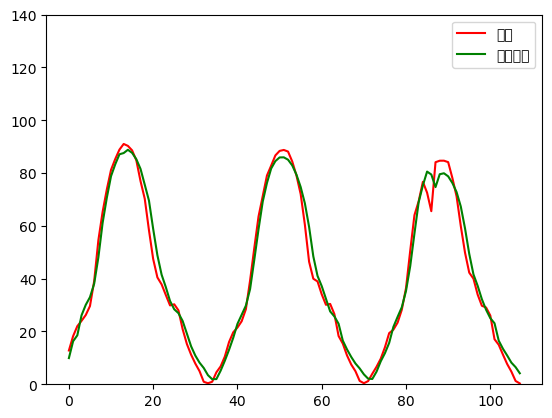

In [11]:
# cloud = [30.722999572753906, 40.91449737548828, 55.121002197265625, 58.66299819946289, 66.29150390625, 72.70449829101562, 78.40799713134766, 37.39999771118164, 39.9739990234375, 45.61149978637695, 54.94499969482422, 44.61050033569336, 28.220500946044922, 14.371500015258789, 13.964499473571777, 20.0364990234375, 24.87649917602539, 20.72949981689453, 27.951000213623047, 61.479000091552734, 40.63399887084961, 118.27200317382812, 40.38100051879883, 18.320499420166016, 93.55500030517578, 86.9990005493164, 92.20199584960938, 72.3635025024414, 38.95100021362305, 37.4109992980957, 47.7234992980957, 29.446998596191406, 48.24599838256836, 68.78849792480469, 28.825498580932617, 25.211999893188477, 23.672000885009766]
plt.plot(measures, color="red", label="晴天")
# plt.plot(cloud, label="阴天")
plt.plot(predict, color="green", label="预测数据")
plt.ylim(0,140)
plt.legend(loc="best")
plt.show()

MSE: 16.521104276374235
RMSE: 4.06461612903042
PICP: 1.0
PINAW: 11.89917100346109


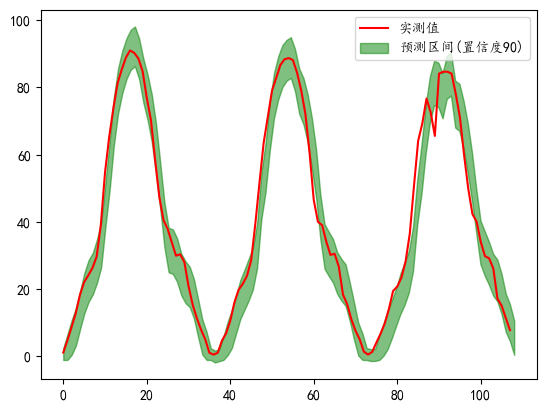

In [23]:
# 参数计算
def MSE(data_true, data_pred):  
    """计算MSE"""  
    return np.mean((data_true - data_pred) ** 2)
def RMSE(data_true, data_pred):  
    """计算RMSE"""
    mse = np.mean((data_true - data_pred) ** 2)
    return np.sqrt(mse)

# 计算MSE和RMSE
data_mear = np.array([measures])
data_pred = np.array([predict])
mse = MSE(data_true = data_mear, data_pred = data_pred)
rmse = RMSE(data_true = data_mear, data_pred = data_pred)
print("MSE:", mse)
print("RMSE:", rmse)

# 置信度95，计算PICP和PINAW
def PICP(data_true, lower_bound, upper_bound): 
    """ 
    计算置信区间覆盖概率
    """ 
    # 计算置信区间覆盖情况，得到布尔值数组 
    covered = (lower_bound <= data_true) & (data_true <= upper_bound) # 计算置信区间覆盖概率 
    picp = np.mean(covered) 
    return picp

def PINAW(lower_bound, upper_bound):
    """
    计算平均区间宽度（PINAW）
    """
    lower_bound = np.array([lower_bound])
    upper_bound = np.array([upper_bound])
    width = upper_bound - lower_bound
    PINAW = np.mean(width)
    return PINAW

confidence = 90
value = predict
a_list95 = []
b_list95 = []
for i in range(0, len(value), 1):
    a,b = cul_interval(value=value[i], confi=confidence)
    a_list95.append(a)
    b_list95.append(b)
picp = PICP(data_true=measures, lower_bound=a_list95, upper_bound=b_list95)
print("PICP:", picp)
pinaw = PINAW(lower_bound=a_list95, upper_bound=b_list95)
print("PINAW:", pinaw)
# plt.plot(a_list95, color="blue")
plt.plot(measures, color="red", label="实测值")
# plt.plot(b_list95, color="blue")
plt.fill_between(x.tolist(), a_list95, b_list95, color='green', alpha=0.5, label='预测区间(置信度90)') 
plt.legend(loc="upper right")
plt.show()